In [7]:
import pandas as pd
import numpy as np
import modeltest as deep
import experiment as exp
import myutil as util
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Reshape, UpSampling2D, Flatten, MaxPooling2D
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import tensorflow as tf
import importlib
importlib.reload(deep)
importlib.reload(exp)

<module 'experiment' from 'C:\\Users\\kyeongtaek\\generative_model\\veichle\\experiment.py'>

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9551474845584975902
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5471625216
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15490310836957023102
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [5]:
#파일 읽기
filepath_german_csv = 'xamain.csv'
d_german_df = pd.read_csv(filepath_german_csv)

#numpy 변환
d_german_np = np.array(d_german_df)

# sample 수, 특징 수 등 계산
n_row = d_german_np.shape[0]
n_features = d_german_np.shape[1]-1

# 입력과 출력 데이터 분리
x = d_german_np[:, :n_features]
y = d_german_np[:, n_features]

#정규화
x_norm = (x - np.min(x,0))/ (np.max(x,0) - np.min(x,0))
y_norm = (y - np.min(y,0))/ (np.max(y,0) - np.min(y,0))

Mapping Block + Resnet40

3/3 [==============================] - 0s 13ms/step
0/10	 test_acc:0.8


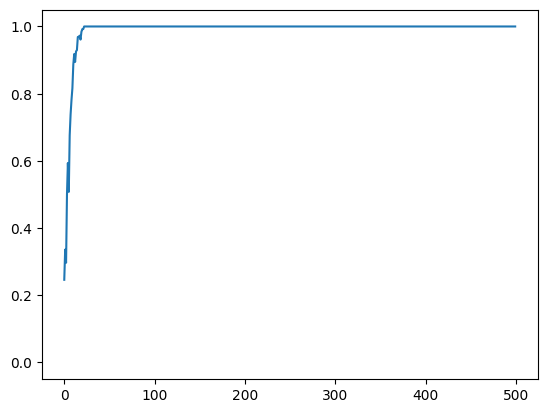

3/3 [==============================] - 0s 15ms/step
1/10	 test_acc:0.7857142857142857


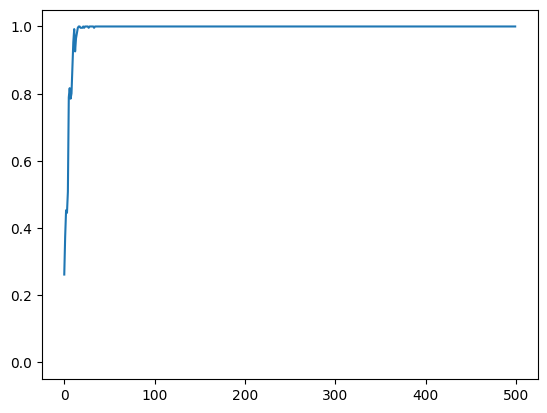

3/3 [==============================] - 0s 18ms/step
2/10	 test_acc:0.7764705882352941


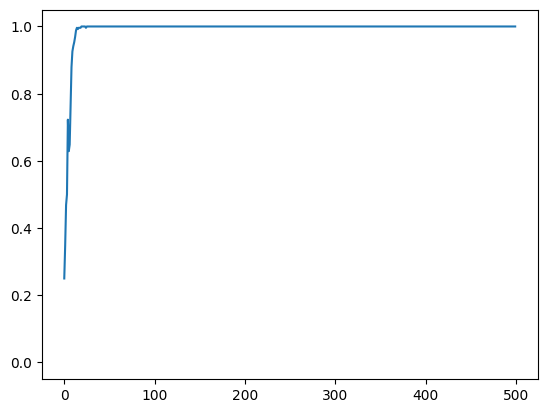

3/3 [==============================] - 0s 16ms/step
3/10	 test_acc:0.8690476190476191


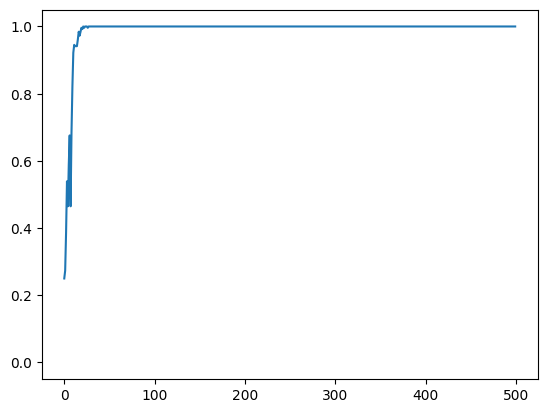

3/3 [==============================] - 0s 16ms/step
4/10	 test_acc:0.7529411764705882


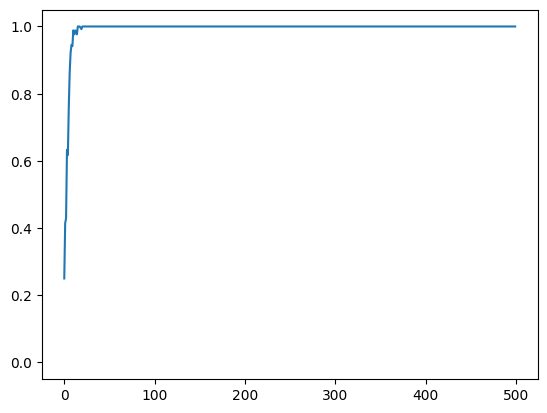

3/3 [==============================] - 0s 17ms/step
5/10	 test_acc:0.6705882352941176


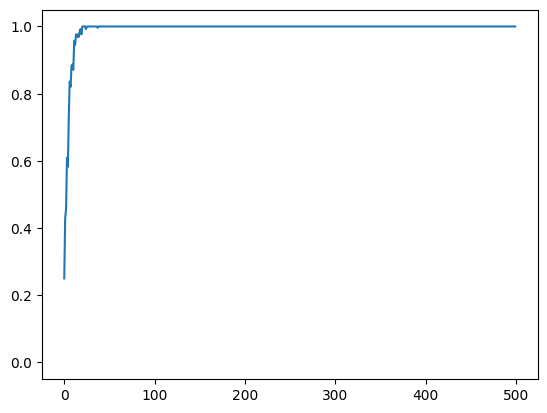

3/3 [==============================] - 0s 13ms/step
6/10	 test_acc:0.7380952380952381


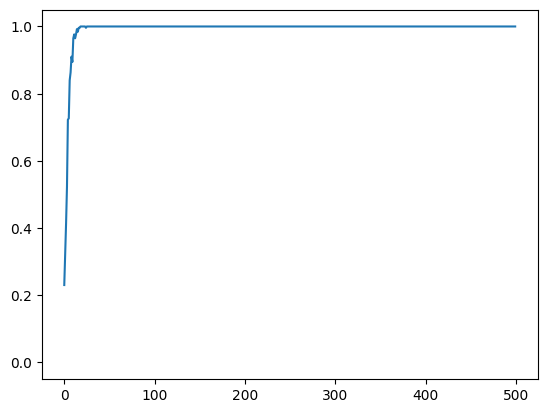

3/3 [==============================] - 0s 10ms/step
7/10	 test_acc:0.7058823529411765


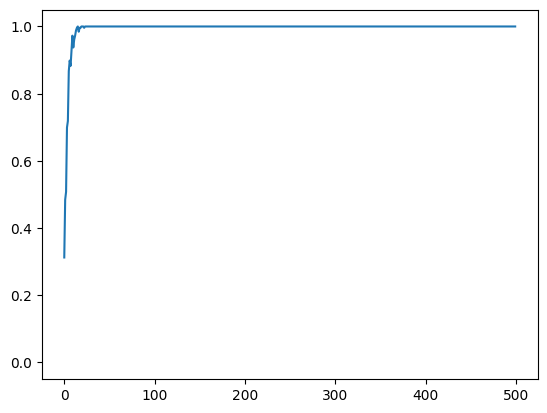

3/3 [==============================] - 0s 8ms/step
8/10	 test_acc:0.7261904761904762


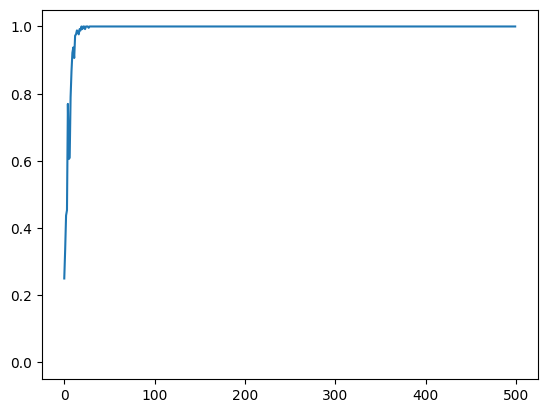

3/3 [==============================] - 0s 8ms/step
9/10	 test_acc:0.8470588235294118


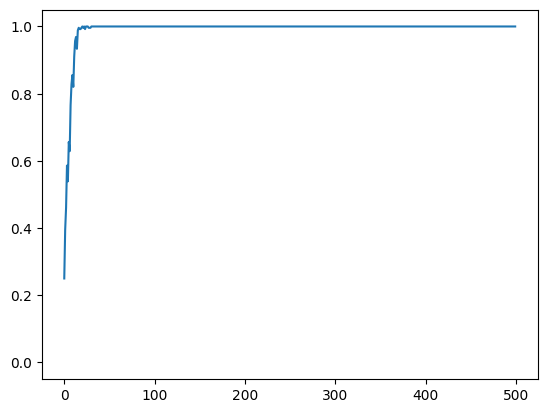

average accuracy : 0.7671988795518208


In [14]:
# 10fold validation 수행여부
bTenFoldValidation = True
if not bTenFoldValidation:  # 학습 & 테스트를 1회만 수행하는 경우
    # 데이터 분할
    [x_train, x_val, x_test, y_train, y_val, y_test] = exp.split_data(x, y, test_ratio=0.0, val_ratio=0.1)

    # 모델 불러오기 & 컴파일
    m = deep.get_model_gen(x.shape[1:])
    m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    # 학습시 사용하는 옵션
    train_options = exp.TrainParams(m, epochs=2000, batch_size_per_class=128)

    # 학습
    result = exp.train_batches_with_random_selection(train_options, x_train, y_train, x_val, y_val)

    # 테스트
    if(x_test.shape[0] > 0):
        test_acc_tmp = np.sum(np.argmax(np.squeeze(result.model.predict(x_test)), -1) == y_test) / y_test.shape[0]
        print(f'test_acc:{test_acc_tmp}')
    # 결과 출력

    plt.plot(result.train_acc)
    plt.plot(result.val_acc)
    plt.show()

else:  # N fold Validation
    idx = np.array(range(n_row))
    np.random.shuffle(idx)  # 데이터 인덱스 섞기

    N = 10
    total = 0
    nClass = 2
    cm = np.zeros([N, nClass, nClass])
    for i in range(N):
        # Train/Test 데이터 분할
        [x_train, x_test, y_train, y_test] = exp.split_data_for_N_fold_validation(x, y, fold=N, idx=i)

        # 모델 불러오기 & 컴파일
        m = deep.get_model_map_fun(x.shape[1:])
        #m = deep.get_model(x.shape[1:])

        # m = deep.get_model(x.shape[1:])
        m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
        m.trainable = False

        # 학습시 사용하는 옵션
        train_options = exp.TrainParams(m, epochs=2000, batch_size_per_class=256)

        # 학습
        result = exp.train_batches_with_random_selection(train_options, x_train, y_train, bVerbose=False)

        #mapping block 학습 결과 저장
        intermediate_layer_model = tf.keras.Model(inputs=m.input, outputs=m.layers[8].output)
        intermediate_layer_model.trainable=False
        
        #final_model 불러오기
        m_f = deep.ResNet50C(x.shape[1:], intermediate_layer_model)
        
        m_f.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
        
        train_options_f = exp.TrainParams(m_f, epochs=500, batch_size_per_class=64)
        
        result_f = exp.train_batches_with_random_selection(train_options_f, x_train, y_train, bVerbose=False)
        
        # 테스트
        o = np.argmax(np.squeeze(result_f.model.predict(x_test)), -1)
        test_acc_tmp = np.sum(o == y_test) / y_test.shape[0]
        #for j in range(y_test.shape[0]):
            #cm[i, int(y_test[j]), int(o[j])] += 1  #Confusion Matrix 계산

        # 결과 출력
        print(f'{i}/{N}\t test_acc:{test_acc_tmp}')
        plt.plot(result_f.train_acc)
        plt.plot(result_f.val_acc)
        plt.show()
        total = total + test_acc_tmp

ave = total/10
print(f'average accuracy : {ave}')

In [11]:
m.summary()

Model: "FunctionalModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 18)]              0         
                                                                 
 Dense1 (Dense)              (None, 5184)              98496     
                                                                 
 BatchNormalization1 (BatchN  (None, 5184)             20736     
 ormalization)                                                   
                                                                 
 Reshape1 (Reshape)          (None, 9, 9, 64)          0         
                                                                 
 UpSampling2D1 (UpSampling2D  (None, 18, 18, 64)       0         
 )                                                               
                                                                 
 Conv2D1 (Conv2D)            (None, 18, 18, 32)    